# DIA Pipeline Analysis 03
#### artifact morphology
This notebook is compatible with `desc-stack-weekly` kernel.

In [18]:
from collections import Counter
import sqlite3
import re
import numpy as np
import pandas as pd
import glob
from astropy.table import Table
from astropy import units as u
from astropy.coordinates import SkyCoord, match_coordinates_sky
from lsst.afw.table import BaseCatalog
import data_process_utils as dpu
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from astropy.visualization import ZScaleInterval
import lsst.afw.image as afwImage
interval = ZScaleInterval()
import lsst.geom as geom
import imp
imp.reload(dpu)

##################################################### flags #########################################################
# 'base_NaiveCentroid_flag' could also be useful
SAT_FLAGS = ['base_PixelFlags_flag_saturated', 'base_PixelFlags_flag_saturatedCenter', 'base_PixelFlags_flag_suspect',
              'base_PixelFlags_flag_suspectCenter', 'base_PixelFlags_flag_offimage', 'base_PixelFlags_flag_edge',
              'base_PixelFlags_flag_bad']
DIPOLE_FLAGS = ['ip_diffim_DipoleFit_flag_classification', 'ip_diffim_DipoleFit_flag_classificationAttempted']
SHAPE_FLAGS = ['base_SdssShape_flag', 'base_GaussianFlux_flag_badShape', 'slot_Shape_flag']

####################### convert number of artifacts per calexp to number of artifacts per deg^2 #####################
CALEXP_TO_DEG2 = 1 / (4000 * 0.2 / 3600 * 4072 * 0.2 / 3600)

################################################# define artifact morphology ########################################
def display_morphology(diff_exp, coadd, calexp, table, row_id, cutout_size = 50, ax_ls=None, title=None, ylabel=True):
    coadd_warped = dpu.warp_to_exposure(coadd, diff_exp)
    calexp_warped = dpu.warp_to_exposure(calexp, diff_exp)
    row = table[row_id]
    x, y = row['base_NaiveCentroid_x'], row['base_NaiveCentroid_y']
    coadd_cutout = dpu.make_cutout(coadd_warped, x, y, cutout_size=cutout_size)
    calexp_cutout = dpu.make_cutout(calexp_warped, x , y, cutout_size=cutout_size)
    diff_cutout = dpu.make_cutout(diff_exp, x, y, cutout_size=cutout_size)
    ax_ls[0].imshow(interval(coadd_cutout.getImage().array), cmap='gray', origin='lower')
    ax_ls[0].set_title(title, size=14)
    ax_ls[1].imshow(interval(calexp_cutout.getImage().array), cmap='gray', origin='lower') 
    ax_ls[2].imshow(interval(diff_cutout.getImage().array), cmap='gray', origin='lower')
    if ylabel:
        ax_ls[0].set_ylabel('coadd', size=14)
        ax_ls[1].set_ylabel('calexp', size=14)
        ax_ls[2].set_ylabel('diff', size=14)
    for ax in ax_ls:
        ax.set_xticks([])
        ax.set_yticks([])

############################################## match diaSrc to background sources ####################################
def match_diaSrc_to_background_source(diaSrc_table, bk_table, radius= 2 * u.arcsec):
    diaSrc_table = diaSrc_table.copy()
    # coordinates of background sources
    bk_coord = SkyCoord(
        np.rad2deg(bk_table['coord_ra'].data), np.rad2deg(bk_table['coord_dec'].data),
        frame="icrs", unit="deg")    
    # coordinates of diaSrc
    diaSrc_coord = SkyCoord(
        np.rad2deg(diaSrc_table['coord_ra'].data), np.rad2deg(diaSrc_table['coord_dec'].data),
        frame="icrs", unit="deg")
    # We use one direction match because one background source can be matched by multiple artifacts
    matched_status, idx = dpu.one_direction_skymatch(diaSrc_coord, bk_coord, radius=radius)
    diaSrc_table['host_ra'] = bk_table['coord_ra'][idx]
    diaSrc_table['host_dec'] = bk_table['coord_dec'][idx]
    diaSrc_table['host_flux'] = bk_table['base_PsfFlux_instFlux'][idx]
    diaSrc_table['host_flux_err'] = bk_table['base_PsfFlux_instFluxErr'][idx]
    diaSrc_table['host_snr'] = diaSrc_table['host_flux'] / diaSrc_table['host_flux_err']
    diaSrc_table['has_host'] = matched_status
    return diaSrc_table

############################################ display postage stamps of difference images #############################
def display_diff_stamps(art_table, diff_dir, figsize=(8,5), hspace=0.4, wspace=0.2):
    fig, ax = plt.subplots(3, 5, figsize=figsize)
    ax_ls = ax.flat
    fig.subplots_adjust(hspace=hspace, wspace=wspace)
    for i, row in enumerate(art_table):
        if i == 15:
            break
        patch = str(row['patch'])
        det = int(row['detector'])
        filt = str(row['filter'])
        visit = int(row['visit'])
        diffexp_path = glob.glob(f'{diff_dir}/{patch}_20_21_{visit}_{det}_{filt}/diff_20/deepDiff/*/*/diffexp*')[0]
        diff_exp = afwImage.ExposureF(diffexp_path)
        x = row['base_NaiveCentroid_x']
        y = row['base_NaiveCentroid_y']
        diff_stamp = dpu.make_cutout(diff_exp, x, y, cutout_size=30)
        ax_ls[i].imshow(interval(diff_stamp.getImage().array), cmap='gray', origin='lower')
        ax_ls[i].set_xticks([])
        ax_ls[i].set_xticks([])
        ax_ls[i].set_yticks([])
        ax_ls[i].set_yticks([])

############################################## artifact fraction with different seeing conditions ######################
def get_seeing_condition_dict(image_info):
    # get seeing condition of image pairs
    # seeing conditions: 
    # fwhm ratio = (calexp fwhm - coadd fwhm) / coadd fwhm
    # braod: fwhm ratio >= 0, near: 0 > fwhm ratio > -0.05, sharp: -0.05 >= fwhm ratio
    seeing_condition_dict = {}
    seeing_condition_pattern = '{patch}_{visit}_{det}_{filt}'
    image_info['fwhm_ratio'] = (image_info['calexp_fwhm'] - image_info['coadd_fwhm']) / image_info['coadd_fwhm']
    for row in image_info:
        patch = row['patch'].replace(',', '')
        visit = row['visit']
        det = row['detector']
        filt = row['filter']
        fwhm_ratio = row['fwhm_ratio']
        seeing_key = seeing_condition_pattern.format(patch=patch, visit=visit, det=det, filt=filt)
        if fwhm_ratio >= 0:
            seeing_condition_dict[seeing_key] = 'broad'
        elif fwhm_ratio < 0 and fwhm_ratio > -0.05:
            seeing_condition_dict[seeing_key] = 'near'
        else:
            seeing_condition_dict[seeing_key] = 'sharp'
    return seeing_condition_dict

def split_diaSrc_by_seeing_condition(detection_astropy, seeing_condition_dict):
    # split diaSrc table into broad, near sharp classes using the seeing_condition_dict
    detection_astropy = detection_astropy.copy()
    seeing_condition_ls = []
    seeing_condition_pattern = '{patch}_{visit}_{det}_{filt}'
    for row in detection_astropy:
        patch, visit = str(row['patch']), int(row['visit'])
        det, filt = int(row['detector']),  str(row['filter'])
        seeing_key = seeing_condition_pattern.format(patch=patch, visit=visit, det=det, filt=filt)
        seeing_condition = seeing_condition_dict[seeing_key]
        seeing_condition_ls.append(seeing_condition)
    detection_astropy['seeing_condition'] = seeing_condition_ls
    broad = detection_astropy[detection_astropy['seeing_condition']=='broad']
    near = detection_astropy[detection_astropy['seeing_condition']=='near']
    sharp = detection_astropy[detection_astropy['seeing_condition']=='sharp']
    return broad, near, sharp

def split_diaSrc_by_flags(detection_astropy, sat_flags, dipole_flags, shape_flags):
    sat = dpu.keep_flag_astropy(detection_astropy, flag_list=sat_flags)
    nonsat = dpu.remove_flag_astropy(detection_astropy, flag_list=sat_flags)
    
    dipole = dpu.keep_flag_astropy(nonsat, flag_list=dipole_flags)
    shape = dpu.keep_flag_astropy(nonsat, flag_list=shape_flags)
    
    dipole_only = dpu.remove_flag_astropy(dipole, flag_list=shape_flags)
    shape_only = dpu.remove_flag_astropy(shape, flag_list=dipole_flags)
    
    both = dpu.keep_flag_astropy(dipole, flag_list=shape_flags)
    
    nondipole = dpu.remove_flag_astropy(nonsat, flag_list=dipole_flags)
    neither = dpu.remove_flag_astropy(nondipole, flag_list=shape_flags)
    
    split_results = {'sat': sat, 'dipole_only': dipole_only,
                     'shape_only': shape_only, 'both': both, 'neither': neither}
    return split_results

def get_fraction(detection_astropy, sat_flags, dipole_flags, shape_flags):
    n_detections = len(detection_astropy)
    split_tables = split_diaSrc_by_flags(detection_astropy, sat_flags, dipole_flags, shape_flags)

    frac_sat = len(split_tables['sat']) / n_detections 
    frac_dipole_only = len(split_tables['dipole_only']) / n_detections
    frac_shape_only = len(split_tables['shape_only']) / n_detections
    frac_both = len(split_tables['both']) / n_detections
    frac_neither = len(split_tables['neither']) / n_detections
    
    art_stat = pd.DataFrame(index=['sat', 'dipole only', 'shape only', 'dipole and shape', 'remaining'])
    art_stat['fraction'] = [frac_sat, frac_dipole_only, frac_shape_only, frac_both, frac_neither]   
    print(art_stat.transpose())
    
################################################## nan-saturation artifacts ###########################################       
def cal_nansat_frac(artifact_table, n_images, sat_flags, calexp_to_deg2=CALEXP_TO_DEG2):
    # calculate the artifact rate (deg^-2) of nan-saturation artifacts
    nonsat = dpu.remove_flag_astropy(artifact_table, flag_list=sat_flags)
    frac_per_image = len(nonsat) / n_images
    frac_per_deg2 = frac_per_image * calexp_to_deg2
    print("number of image pairs: ", n_images)
    print("number of non-saturation artifacats from image pairs: ", len(nonsat))
    print("number of non-saturation artifacts pers detector: ", frac_per_image)
    print("number of non-saturation artifacts per deg^2: ", frac_per_deg2)
    
############################################# artifact fraction at different snr #####################################       
def cal_art_fraction(background_table, x_min, x_max, dx):
    x_arr = np.arange(x_min, x_max, dx)
    background_table['snr'] = background_table['base_PsfFlux_instFlux'] / background_table['base_PsfFlux_instFluxErr']
    frac_list = []
    for i in x_arr:
        low = i
        high = i + dx
        keep = np.logical_and(background_table['snr']>low, background_table['snr']<=high)
        source_kept = background_table[keep]
        condition = np.logical_and(source_kept['is_diaSrc'] == 'True', source_kept['is_fake'] == 'False')
        frac = np.sum(condition) / len(source_kept)
        frac_list.append(frac)  
    return frac_list   

def display_nonsaturaion_artifacts(diff_dir, art_table, sat_flags, dipole_flags, shape_flags,
                                   figsize=(8,7), hspace=0.4, wspace=0.2):
    diffexp_path_pattern = '{diff_dir}/{patch}_20_21_{visit}_{det}_{filt}/diff_20/deepDiff/*/*/diffexp*'
    split_tables = split_diaSrc_by_flags(art_table, sat_flags, dipole_flags, shape_flags)

    fig, ax = plt.subplots(4, 5, figsize=figsize)
    fig.subplots_adjust(hspace=hspace, wspace=wspace)

    table_ls = [split_tables['both'], split_tables['dipole_only'],
                split_tables['shape_only'], split_tables['neither']]
    ylabel_ls = ['both', 'dipole', 'shape', 'neither']
    
    for r in range(4):
        t = table_ls[r]
        ylabel = ylabel_ls[r]
        for c, row in enumerate(t):
            if c == 5:
                break
            patch = str(row['patch'])
            det = int(row['detector'])
            filt = str(row['filter'])
            visit = int(row['visit'])
            diffexp_path = glob.glob(
                diffexp_path_pattern.format(diff_dir=diff_dir, patch=patch, visit=visit, det=det, filt=filt)
            )[0]
            diff_exp = afwImage.ExposureF(diffexp_path)
            x = row['base_NaiveCentroid_x']
            y = row['base_NaiveCentroid_y']
            diff_stamp = dpu.make_cutout(diff_exp, x, y, cutout_size=30)
            ax[r][c].imshow(interval(diff_stamp.getImage().array), cmap='gray', origin='lower')
            ax[r][c].set_xticks([])
            ax[r][c].set_xticks([])
            ax[r][c].set_yticks([])
            ax[r][c].set_yticks([])
            if c == 0:
                ax[r][c].set_ylabel(ylabel, size=16)
                
###################################### plot host SNR with different seeing conditions ############################


############################################## AL vs. ZOGY ##############################################   
def display_al_zogy(coadd, calexp, al_diff, zogy_diff, dipole_table):
    coadd_warped = dpu.warp_to_exposure(coadd, al_diff)
    calexp_warped = dpu.warp_to_exposure(calexp, al_diff)
    zogy_warped = dpu.warp_to_exposure(zogy_diff, al_diff)
    
    fig, ax = plt.subplots(4, 5, figsize=(7,5.6))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i in range(5):
        row = dipole_table[i]

        x = row['base_NaiveCentroid_x']
        y = row['base_NaiveCentroid_y']
        coadd_stamp = dpu.make_cutout(coadd_warped, x, y, cutout_size=30)
        calexp_stamp = dpu.make_cutout(calexp_warped, x, y, cutout_size=30)
        al_stamp = dpu.make_cutout(al_diff, x, y, cutout_size=30)
        zogy_stamp = dpu.make_cutout(zogy_warped, x, y, cutout_size=30)
        ax[0][i].imshow(interval(coadd_stamp.getImage().array), cmap='gray', origin='lower')
        ax[1][i].imshow(interval(calexp_stamp.getImage().array), cmap='gray', origin='lower')
        ax[2][i].imshow(interval(al_stamp.getImage().array), cmap='gray', origin='lower')
        ax[3][i].imshow(interval(zogy_stamp.getImage().array), cmap='gray', origin='lower')
        if i == 0:
            ax[0][i].set_ylabel('coadd', size=16)
            ax[1][i].set_ylabel('calexp', size=16)
            ax[2][i].set_ylabel('AL', size=16)
            ax[3][i].set_ylabel('ZOGY', size=16)
        for r in range(4):
            ax[r][i].set_xticks([])
            ax[r][i].set_yticks([])

#### Artifact morphology: definition

difference images used in this analysis:
calexp fwhm > coadd fwhm:
./data/patch_0to6/diff/al_default_v23/66_20_21_420784_59_i/diff_20/deepDiff/v00420784-fi/R13/diffexp_00420784-i-R13-S12-det059.fits
calexp fwhm < coadd fwhm:
./data/patch_0to6/diff/al_default_v23/22_20_21_951317_170_i/diff_20/deepDiff/v00951317-fi/R41/diffexp_00951317-i-R41-S22-det170.fits


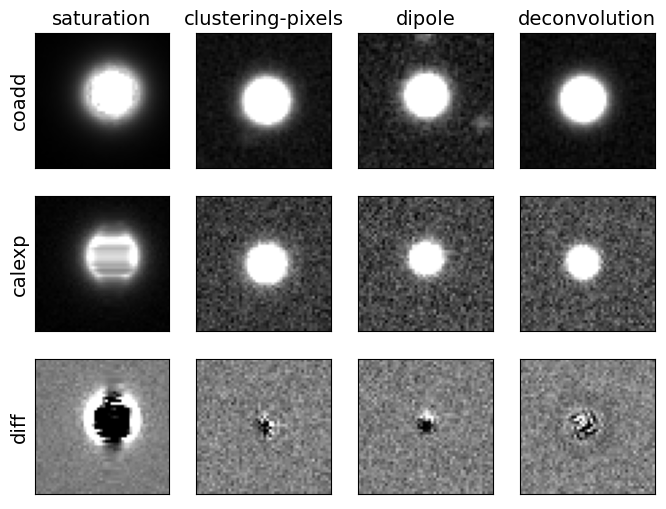

In [8]:
data_dir = '/pscratch/sd/s/shl159/Cori/projects/fake_injection_v23/dia_improvement/devel/data'
image_info = Table.read(f'{data_dir}/table/gal_4639/image_info_20_21_m20.csv', format='ascii.csv')
print('difference images used in this analysis:')
print('calexp fwhm > coadd fwhm:')
print(image_info[1]['diffexp_path'])
print('calexp fwhm < coadd fwhm:')
print(image_info[4]['diffexp_path'])

coadd = afwImage.ExposureF(f'{data_dir}/patch_0to6/coadd/coadd_4639_66.fits')
calexp = afwImage.ExposureF(f'{data_dir}/patch_0to6/injection/66_20_21_420784_59_i/fake_20/calexp/00420784-i/R13/calexp_00420784-i-R13-S12-det059.fits')
coadd_deconv = afwImage.ExposureF(f'{data_dir}/patch_0to6/coadd/coadd_4639_22.fits')
calexp_deconv = afwImage.ExposureF(f'{data_dir}/patch_0to6/injection/22_20_21_951317_170_i/fake_20/calexp/00951317-i/R41/calexp_00951317-i-R41-S22-det170.fits')

diff = afwImage.ExposureF(image_info[1]['diffexp_path'].replace('./data', f'{data_dir}'))
diaSrc = BaseCatalog.readFits(image_info[1]['diaSrc_path'].replace('./data', f'{data_dir}'))
diaSrc = diaSrc.asAstropy()
diaSrc_sat = dpu.keep_flag_astropy(diaSrc, flag_list=SAT_FLAGS)
diaSrc_nonsat = dpu.remove_flag_astropy(diaSrc, flag_list=SAT_FLAGS)
diaSrc_dipole = dpu.keep_flag_astropy(diaSrc_nonsat, flag_list=DIPOLE_FLAGS)
diaSrc_remaining = dpu.remove_flag_astropy(diaSrc_nonsat, flag_list=DIPOLE_FLAGS)

diff_deconv = afwImage.ExposureF(image_info[4]['diffexp_path'].replace('./data', f'{data_dir}'))
diaSrc_deconv = BaseCatalog.readFits(image_info[4]['diaSrc_path'].replace('./data', f'{data_dir}'))
diaSrc_deconv = diaSrc_deconv.asAstropy()
diaSrc_deconv = dpu.remove_flag_astropy(diaSrc_deconv, flag_list=SAT_FLAGS)

fig, ax = plt.subplots(3, 4, figsize=(8,6))
display_morphology(diff, coadd, calexp, diaSrc_sat, row_id=1, ax_ls=[ax[0][0], ax[1][0], ax[2][0]], title='saturation')
display_morphology(diff, coadd, calexp, diaSrc_remaining, row_id=7, ax_ls=[ax[0][1], ax[1][1], ax[2][1]], title='clustering-pixels', ylabel=False)
display_morphology(diff, coadd, calexp, diaSrc_dipole, row_id=7, ax_ls=[ax[0][2], ax[1][2], ax[2][2]], title='dipole', ylabel=False)
display_morphology(diff_deconv, coadd_deconv, calexp_deconv, diaSrc_deconv, row_id=5, ax_ls=[ax[0][3], ax[1][3], ax[2][3]], title='deconvolution', ylabel=False)
plt.savefig('./plots_and_tables/art_definition.pdf')

#### Artifact Statistics

In [29]:
db = f'./data/patch_0to6/diff/al_default_v23/detection/detection.sqlite'
conn = sqlite3.connect(db)
art = pd.read_sql_query("SELECT * FROM artifact WHERE host_mag = '20_21' and fake_mag = 20", conn)
art_astropy = Table.from_pandas(art)
image_info = Table.read('./data/table/gal_4639/image_info_20_21_m20.csv', format='ascii.csv')
seeing_condition_dict = get_seeing_condition_dict(image_info)
# split artifacts into broad, near, sharp class
broad, near, sharp = split_diaSrc_by_seeing_condition(art_astropy, seeing_condition_dict)
# count the number of image pairs with different seeing conditions
seeing_count = Counter(seeing_condition_dict.values())
n_broad, n_near, n_sharp = seeing_count['broad'], seeing_count['near'], seeing_count['sharp']

print('broad')
get_fraction(broad, SAT_FLAGS, DIPOLE_FLAGS, SHAPE_FLAGS)
cal_nansat_frac(broad, n_broad, SAT_FLAGS, calexp_to_deg2=CALEXP_TO_DEG2)
print('\n')
print('near')
get_fraction(near, SAT_FLAGS, DIPOLE_FLAGS, SHAPE_FLAGS)
cal_nansat_frac(near, n_near, SAT_FLAGS, calexp_to_deg2=CALEXP_TO_DEG2)
print('\n')
print('sharp')
get_fraction(sharp, SAT_FLAGS, DIPOLE_FLAGS, SHAPE_FLAGS)
cal_nansat_frac(sharp, n_sharp, SAT_FLAGS, calexp_to_deg2=CALEXP_TO_DEG2)

broad
               sat  dipole only  shape only  dipole and shape  remaining
fraction  0.518973     0.014509    0.251116          0.122768   0.092634
number of image pairs:  30
number of non-saturation artifacats from image pairs:  431
number of non-saturation artifacts pers detector:  14.366666666666667
number of non-saturation artifacts per deg^2:  285.78094302554035


near
               sat  dipole only  shape only  dipole and shape  remaining
fraction  0.475992     0.029228    0.248434          0.127349   0.118998
number of image pairs:  16
number of non-saturation artifacats from image pairs:  251
number of non-saturation artifacts pers detector:  15.6875
number of non-saturation artifacts per deg^2:  312.05488703339887


sharp
               sat  dipole only  shape only  dipole and shape  remaining
fraction  0.533147     0.030812    0.217554          0.121382   0.097106
number of image pairs:  24
number of non-saturation artifacats from image pairs:  500
number of non-saturati

#### Artifact fraction at different SNR

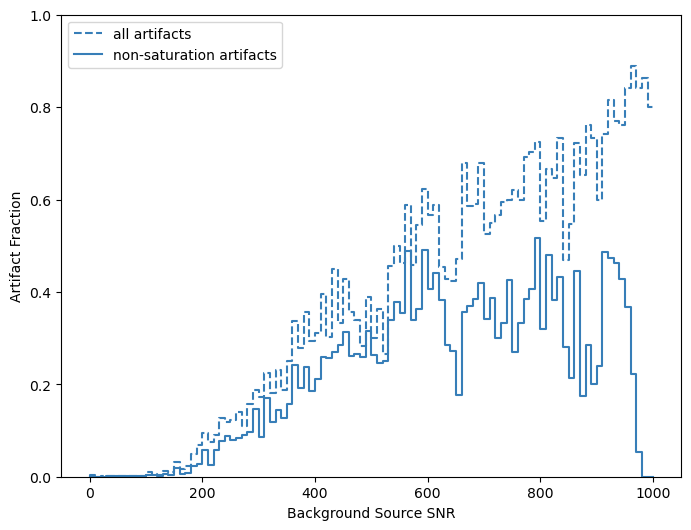

In [5]:
background_src = Table.read('./data/table/gal_4639/background_sources.csv', format='ascii.csv')
background_src_sat_removed = Table.read('./data/table/gal_4639/background_sources_sat_flag_applied.csv', format='ascii.csv')

x_min, x_max = -10, 1000
dx = 10

CBCC = ['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']

art_frac =  cal_art_fraction(background_src, x_min, x_max, dx)
art_frac_sat_removed = cal_art_fraction(background_src_sat_removed, x_min, x_max, dx)
plt.figure(figsize=(8, 6))
plt.step(np.arange(x_min+dx, x_max+dx, dx),  art_frac, color=CBCC[0], linestyle='--', label='all artifacts')
plt.step(np.arange(x_min+dx, x_max+dx, dx),  art_frac_sat_removed, color=CBCC[0], label='non-saturation artifacts')
plt.ylim(0, 1)
plt.ylabel('Artifact Fraction')
plt.xlabel('Background Source SNR')
plt.legend()
plt.savefig('./plots_and_tables/sat_frac_vs_host_snr.pdf')

#### Fraction of saturation and non-saturation artifacts which are from background sources. (one-direction match)

In [20]:
background_src = Table.read('./data/table/gal_4639/background_sources.csv', format='ascii.csv')
db = f'./data/patch_0to6/diff/al_default_v23/detection/detection.sqlite'
conn = sqlite3.connect(db)
art = pd.read_sql_query("SELECT * FROM artifact WHERE host_mag = '20_21' and fake_mag = 20", conn)
art_astropy = Table.from_pandas(art)

art_sat = dpu.keep_flag_astropy(art_astropy, flag_list=SAT_FLAGS)
art_nonsat = dpu.remove_flag_astropy(art_astropy, flag_list=SAT_FLAGS)

print('We use one direction match because one background source can be matched by multiple artifacts')
art_sat = match_diaSrc_to_background_source(art_sat, background_src, radius= 2 * u.arcsec)
art_nonsat = match_diaSrc_to_background_source(art_nonsat, background_src, radius= 2 * u.arcsec)
print('The fraction of saturation artifacts which have matches from background sources: ',
      art_sat['has_host'].sum() / len(art_sat))
print('The fraction of non-saturation artifacts which have matches from background sources: ',
      art_nonsat['has_host'].sum() / len(art_nonsat))

We use one direction match because one background source can be matched by multiple artifacts
The fraction of saturation artifacts which have matches from background sources:  0.8109177215189873
The fraction of non-saturation artifacts which have matches from background sources:  0.8020304568527918


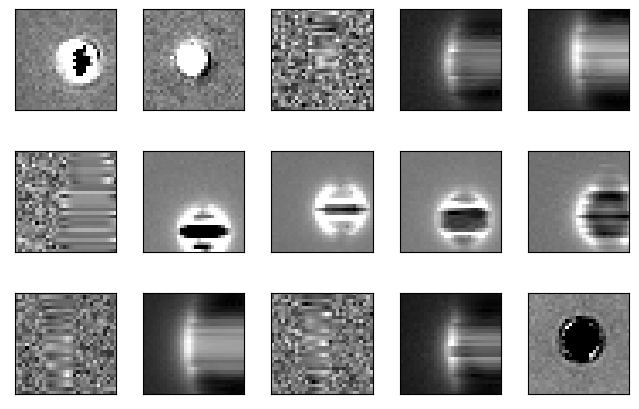

In [46]:
diff_dir = './data/patch_0to6/diff/al_default_v23/'
art_sat_matched = art_sat[art_sat['has_host']==True]
display_diff_stamps(art_sat_matched, diff_dir)

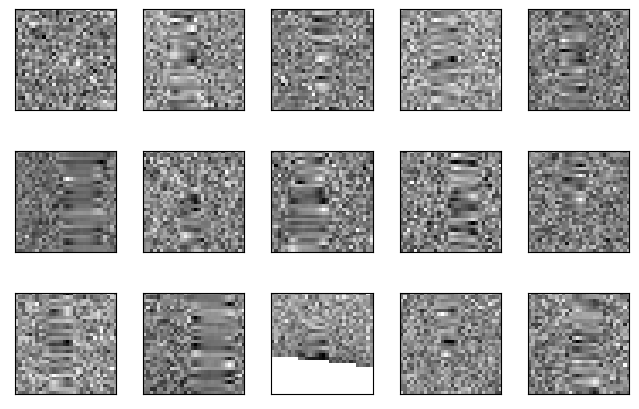

In [47]:
diff_dir = './data/patch_0to6/diff/al_default_v23/'
art_sat_not_matched = art_sat[art_sat['has_host']==False]
display_diff_stamps(art_sat_not_matched, diff_dir)

#### Artifact morphology: dipole flag and shape flag

In [45]:
db = f'./data/patch_0to6/diff/al_default_v23/detection/detection.sqlite'
conn = sqlite3.connect(db)
art = pd.read_sql_query("SELECT * FROM artifact WHERE host_mag = '20_21' and fake_mag = 20", conn)
art_astropy = Table.from_pandas(art)
image_info = Table.read('./data/table/gal_4639/image_info_20_21_m20.csv', format='ascii.csv')
seeing_condition_dict = get_seeing_condition_dict(image_info)
# split artifacts into broad, near, sharp class
broad, near, sharp = split_diaSrc_by_seeing_condition(art_astropy, seeing_condition_dict)
diff_dir = './data/patch_0to6/diff/al_default_v23/'

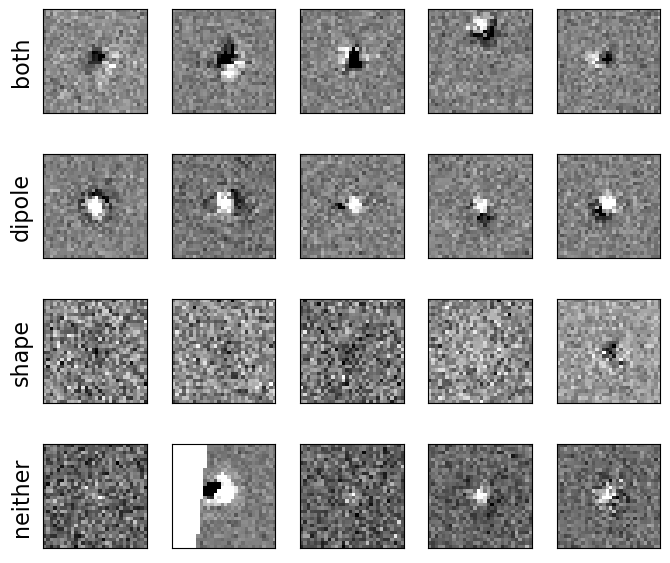

In [46]:
# braod class
display_nonsaturaion_artifacts(diff_dir, broad, SAT_FLAGS, DIPOLE_FLAGS, SHAPE_FLAGS)
plt.savefig('./plots_and_tables/art_broad.pdf')

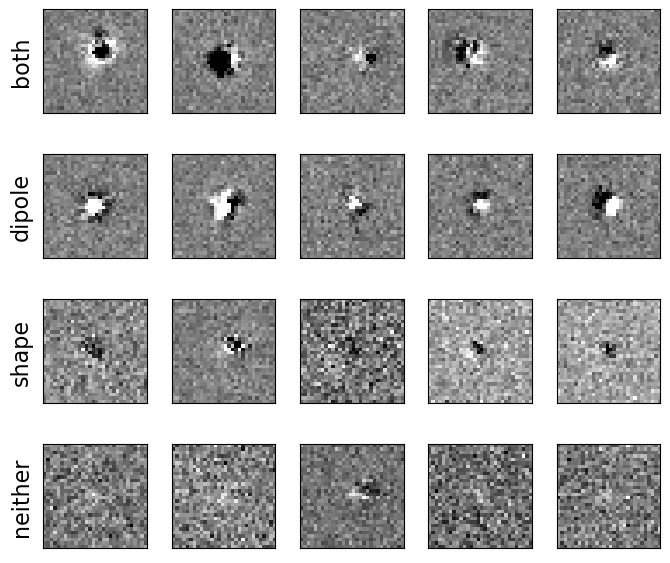

In [47]:
# near class
display_nonsaturaion_artifacts(diff_dir, near, SAT_FLAGS, DIPOLE_FLAGS, SHAPE_FLAGS)
plt.savefig('./plots_and_tables/art_near.pdf')

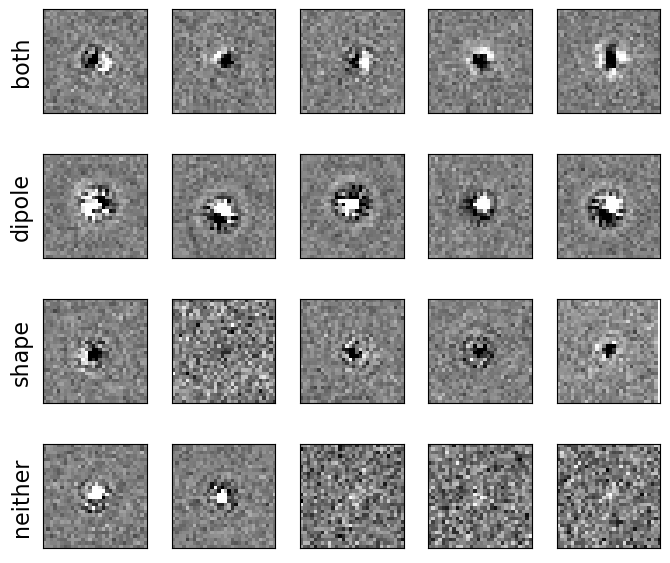

In [48]:
# sharp class
display_nonsaturaion_artifacts(diff_dir, sharp, SAT_FLAGS, DIPOLE_FLAGS, SHAPE_FLAGS)
plt.savefig('./plots_and_tables/art_sharp.pdf')

#### Artifact morphology: host SNR

In [84]:
def plot_host_snr_with_different_seeing_conditions(broad_matched, near_matched, sharp_matched):
    fig, ax = plt.subplots(1,3,figsize=(13, 6))
    fig.subplots_adjust(wspace=0.2)
    bins = np.arange(0, 1010, 10)
    titlesize = 20
    labelsize = 20
    ticksize=18
    xticks = [0, 200, 600, 1000]
    yticks = [0, 5, 10, 15, 20]
    ylim = (0, 20)
    ax[0].hist(broad_matched['host_snr'], bins=bins, histtype='step')
    ax[0].set_xticks(xticks)
    ax[0].set_xticklabels(xticks, fontsize=ticksize)
    ax[0].set_yticks(yticks)
    ax[0].set_yticklabels(yticks, fontsize=ticksize)
    ax[0].set_ylim(ylim)
    ax[0].set_xlabel('SNR', size=labelsize)
    ax[0].set_ylabel('Sources / SNR Bin', size=labelsize)
    # ax[0].set_xlabel('Source SNR', size=labelsize)
    ax[0].set_title("Broad", size=titlesize)
    
    ax[1].hist(near_matched['host_snr'], bins=bins, histtype='step')
    ax[1].set_xticks(xticks)
    ax[1].set_xticklabels(xticks, fontsize=ticksize)
    # ax[1].set_yticks(yticks)
    # ax[1].set_yticklabels(yticks, fontsize=labelsize)
    ax[1].set_yticks([])
    ax[1].set_yticklabels([])
    ax[1].set_ylim(ylim)
    ax[1].set_xlabel('SNR', size=labelsize)
    # ax[1].set_xlabel('Source SNR', size=labelsize)
    ax[1].set_title("Near", size=titlesize)
    
    ax[2].hist(sharp_matched['host_snr'], bins=bins, histtype='step')
    ax[2].set_xticks(xticks)
    ax[2].set_xticklabels(xticks, fontsize=ticksize)
    # ax[2].set_yticks(yticks)
    # ax[2].set_yticklabels(yticks, fontsize=labelsize)
    ax[2].set_yticks([])
    ax[2].set_yticklabels([])
    ax[2].set_ylim(ylim)
    ax[2].set_xlabel('SNR', size=labelsize)
    ax[2].set_title("Sharp", size=titlesize)


We use one direction match because one background source can be matched by multiple artifacts


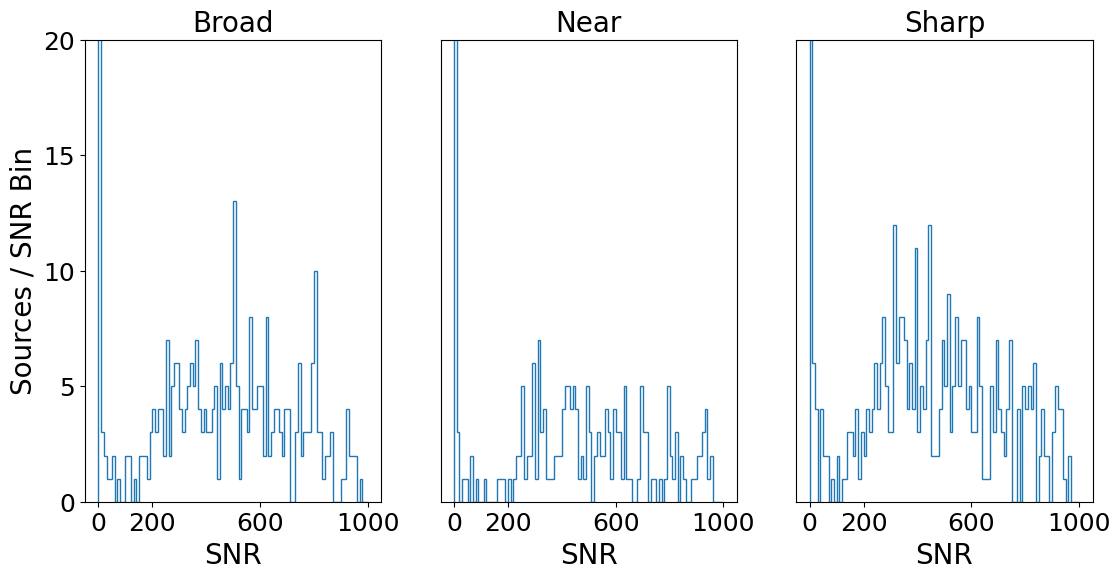

In [85]:
# image information
image_info = Table.read('./data/table/gal_4639/image_info_20_21_m20.csv', format='ascii.csv')
seeing_condition_dict = get_seeing_condition_dict(image_info)
# background source
background_src = Table.read('./data/table/gal_4639/background_sources.csv', format='ascii.csv')
db = f'/pscratch/sd/s/shl159/Cori/projects/fake_injection_v23/dia_improvement/devel/data/patch_0to6/diff/al_default_v23/detection/detection.sqlite'
conn = sqlite3.connect(db)
art = pd.read_sql_query("SELECT * FROM artifact WHERE host_mag = '20_21' and fake_mag = 20", conn)
art_astropy = Table.from_pandas(art)
print('We use one direction match because one background source can be matched by multiple artifacts')
art_astropy= match_diaSrc_to_background_source(art_astropy, background_src, radius= 2 * u.arcsec)
art_nonsat = dpu.remove_flag_astropy(art_astropy, flag_list=SAT_FLAGS)
nonsat_matched = art_nonsat[art_nonsat['has_host'] == True]

broad_matched, near_matched, sharp_matched = split_diaSrc_by_seeing_condition(nonsat_matched, seeing_condition_dict)
plot_host_snr_with_different_seeing_conditions(broad_matched, near_matched, sharp_matched)
plt.savefig('./plots_and_tables/nonsat_host_snr.pdf')

#### Artifact Morphology: faint host

In [41]:
def display_coadd_calexp_diff(art_table, coadd_dir, calexp_dir, diff_dir, hspace=0.4, wspace=0.21, figsize=(8,4.8)):
    fig, ax = plt.subplots(3, 5, figsize=figsize)
    fig.subplots_adjust(hspace=hspace, wspace=wspace)
    for c, row in enumerate(art_table):
        if c == 5:
            break
        patch = str(row['patch'])
        det = int(row['detector'])
        filt = str(row['filter'])
        visit = int(row['visit'])
        
        diff_path = glob.glob(f'{diff_dir}/{patch}_20_21_{visit}_{det}_{filt}/diff_20/deepDiff/*/*/diffexp*')[0]
        coadd_path = f'{coadd_dir}/coadd_4639_{patch}.fits'
        calexp_path = glob.glob(f'{calexp_dir}/{patch}_20_21_{visit}_{det}_{filt}/fake_20/calexp/*/*/calexp*')[0]
        
        diff_exp = afwImage.ExposureF(diff_path)
        coadd_exp = afwImage.ExposureF(coadd_path)
        calexp_exp = afwImage.ExposureF(calexp_path)
        
        coadd_warped = dpu.warp_to_exposure(coadd_exp, diff_exp)
        calexp_warped = dpu.warp_to_exposure(calexp_exp, diff_exp)
        
        x = row['base_NaiveCentroid_x']
        y = row['base_NaiveCentroid_y']
        
        coadd_stamp = dpu.make_cutout(coadd_warped, x, y, cutout_size=30)
        calexp_stamp = dpu.make_cutout(calexp_warped, x, y, cutout_size=30)
        diff_stamp = dpu.make_cutout(diff_exp, x, y, cutout_size=30)
        ax[0][c].imshow(interval(coadd_stamp.getImage().array), cmap='gray', origin='lower')
        ax[1][c].imshow(interval(calexp_stamp.getImage().array), cmap='gray', origin='lower')
        ax[2][c].imshow(interval(diff_stamp.getImage().array), cmap='gray', origin='lower')
        if c == 0:
            ax[0][c].set_ylabel('coadd', size=16)
            ax[1][c].set_ylabel('calexp', size=16)
            ax[2][c].set_ylabel('diff', size=16)
        for i in range(3):
            ax[i][c].set_xticks([])
            ax[i][c].set_yticks([])

We use one direction match because one background source can be matched by multiple artifacts


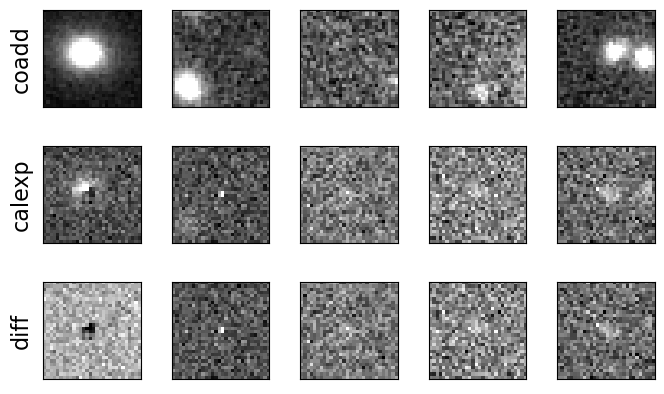

In [42]:
# background source
background_src = Table.read('./data/table/gal_4639/background_sources.csv', format='ascii.csv')
db = f'./data/patch_0to6/diff/al_default_v23/detection/detection.sqlite'
conn = sqlite3.connect(db)
art = pd.read_sql_query("SELECT * FROM artifact WHERE host_mag = '20_21' and fake_mag = 20", conn)
art_astropy = Table.from_pandas(art)
print('We use one direction match because one background source can be matched by multiple artifacts')
art_astropy= match_diaSrc_to_background_source(art_astropy, background_src, radius= 2 * u.arcsec)
art_nonsat = dpu.remove_flag_astropy(art_astropy, flag_list=SAT_FLAGS)
nonsat_matched = art_nonsat[art_nonsat['has_host'] == True]
nonsat_faint_host = nonsat_matched[nonsat_matched['host_snr'] < 50]

diff_dir = './data/patch_0to6/diff/al_default_v23/'
coadd_dir = './data/patch_0to6/coadd'
calexp_dir = './data/patch_0to6/injection'

display_coadd_calexp_diff(nonsat_faint_host[[9,13,14,21, 22, 23]], coadd_dir, calexp_dir, diff_dir)
plt.savefig('./plots_and_tables/art_faint_host.pdf')

#### Artifact Morphology: unmatched

We use one direction match because one background source can be matched by multiple artifacts
broad
number of image pairs:  30
number of non-saturation artifacats from image pairs:  93
number of non-saturation artifacts pers detector:  3.1
number of non-saturation artifacts per deg^2:  61.665029469548145


near
number of image pairs:  16
number of non-saturation artifacats from image pairs:  46
number of non-saturation artifacts pers detector:  2.875
number of non-saturation artifacts per deg^2:  57.18934184675836


sharp
number of image pairs:  24
number of non-saturation artifacats from image pairs:  95
number of non-saturation artifacts pers detector:  3.9583333333333335
number of non-saturation artifacts per deg^2:  78.73894891944992


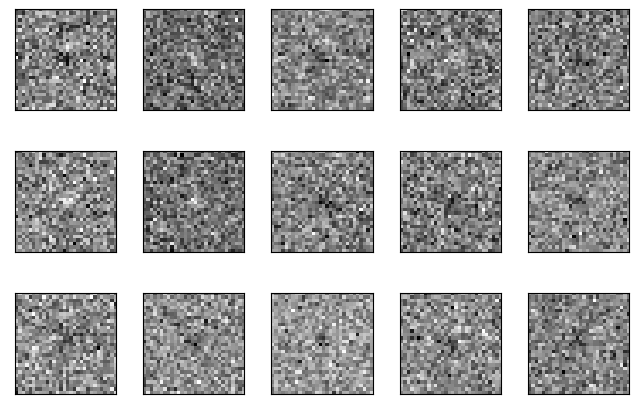

In [11]:
# background source
background_src = Table.read('./data/table/gal_4639/background_sources.csv', format='ascii.csv')
db = f'./data/patch_0to6/diff/al_default_v23/detection/detection.sqlite'
conn = sqlite3.connect(db)
art = pd.read_sql_query("SELECT * FROM artifact WHERE host_mag = '20_21' and fake_mag = 20", conn)
art_astropy = Table.from_pandas(art)
print('We use one direction match because one background source can be matched by multiple artifacts')
art_astropy= match_diaSrc_to_background_source(art_astropy, background_src, radius= 2 * u.arcsec)
art_nonsat = dpu.remove_flag_astropy(art_astropy, flag_list=SAT_FLAGS)
nonsat_unmatched = art_nonsat[art_nonsat['has_host'] == False]

image_info = Table.read('./data/table/gal_4639/image_info_20_21_m20.csv', format='ascii.csv')
seeing_condition_dict = get_seeing_condition_dict(image_info)
# count the number of image pairs with different seeing conditions
seeing_count = Counter(seeing_condition_dict.values())
n_broad, n_near, n_sharp = seeing_count['broad'], seeing_count['near'], seeing_count['sharp']
# split artifacts into broad, near, sharp class
broad_unmatched, near_unmatched, sharp_unmatched = split_diaSrc_by_seeing_condition(nonsat_unmatched, seeing_condition_dict)


print('broad')
cal_nansat_frac(broad_unmatched, n_broad, SAT_FLAGS, calexp_to_deg2=CALEXP_TO_DEG2)
print('\n')
print('near')
cal_nansat_frac(near_unmatched, n_near, SAT_FLAGS, calexp_to_deg2=CALEXP_TO_DEG2)
print('\n')
print('sharp')
cal_nansat_frac(sharp_unmatched, n_sharp, SAT_FLAGS, calexp_to_deg2=CALEXP_TO_DEG2)

diff_dir = './data/patch_0to6/diff/al_default_v23/'
# nonsat_unmatched[13] has an artifact with inaccurate calculation of position
# we skip that artifact
display_diff_stamps(nonsat_unmatched[14:], diff_dir)
plt.savefig('./plots_and_tables/art_unmatched.pdf')

#### Artifact Morphology: AL vs. ZOGY

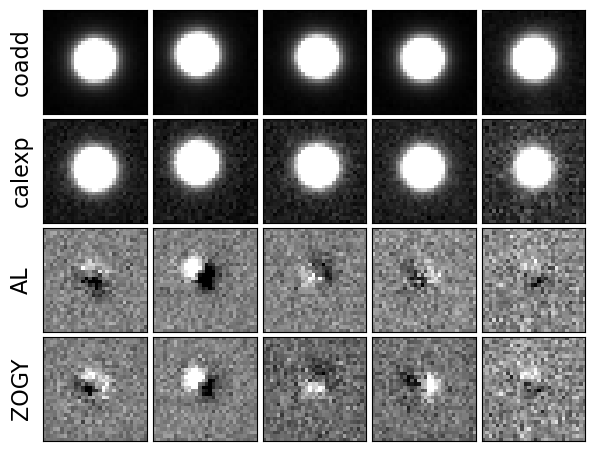

In [12]:
coadd = afwImage.ExposureF('./data/patch_0to6/diff/dipole_examples/coadd/coadd_4639_00.fits')
calexp = afwImage.ExposureF('./data/patch_0to6/injection/00_20_21_1013665_79_i/fake_20/calexp/01013665-i/R20/calexp_01013665-i-R20-S21-det079.fits')
al_diff = afwImage.ExposureF('./data/patch_0to6/diff/dipole_examples/al/deepDiff/v01013665-fi/R20/diffexp_01013665-i-R20-S21-det079.fits')
zogy_diff = afwImage.ExposureF('./data/patch_0to6/diff/dipole_examples/zogy/deepDiff/v01013665-fi/R20/diffexp_01013665-i-R20-S21-det079.fits')

diff_diaSrc = BaseCatalog.readFits('./data/patch_0to6/diff/dipole_examples/al/deepDiff/v01013665-fi/R20/diaSrc_01013665-i-R20-S21-det079.fits')
diff_diaSrc_astropy = diff_diaSrc.asAstropy()

diaSrc_nonsat = dpu.remove_flag_astropy(diff_diaSrc_astropy, flag_list=SAT_FLAGS)
diaSrc_dipole = dpu.keep_flag_astropy(diaSrc_nonsat, flag_list=DIPOLE_FLAGS)

display_al_zogy(coadd, calexp, al_diff, zogy_diff, diaSrc_dipole[1:])
plt.savefig('./plots_and_tables/al_zogy.pdf')